In [7]:
import csv
import pandas as pd
import numpy as np
import os

current_movie = None

with open('total_data.csv','w',newline='') as total_data:
    csv_writer = csv.writer(total_data, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    files = ['./combined_data_1.txt','./combined_data_2.txt','./combined_data_3.txt', './combined_data_4.txt']
    for file in files:
        print("reading " + file)
        with open(file) as current_file: 
            for current_row in current_file:
                current_row = current_row.strip()
                if current_row[-1] == ":":
                    current_movie = current_row[:len(current_row)-1]
                else:
                    new_row = [current_movie]
                    for element in current_row.split(","):
                        new_row.append(element)
                    csv_writer.writerow(new_row)
        print("completed " + file +"\n")

reading ./combined_data_1.txt
completed ./combined_data_1.txt

reading ./combined_data_2.txt
completed ./combined_data_2.txt

reading ./combined_data_3.txt
completed ./combined_data_3.txt

reading ./combined_data_4.txt
completed ./combined_data_4.txt



In [8]:
data_frame = pd.read_csv('./total_data.csv', sep=',', names=['movieId', 'userId','currentRating','date'])
data_frame.date = pd.to_datetime(data_frame.date)
data_frame.sort_values(by='date', inplace=True)

In [10]:
print("Complete Data:")
print("Number of movie ratings  = "+str(data_frame.shape[0]))
print("Number of users = "+str(len(np.unique(data_frame["userId"]))))
print("Number of movies = "+str(len(np.unique(data_frame["movieId"]))))
print("Largest User ID = "+str(max(data_frame["userId"].values)))
print("Largest Movie ID = "+str(max(data_frame["movieId"].values)))

Complete Data:
Number of movie ratings  = 100480507
Number of users = 480189
Number of movies = 17770
Largest User ID = 2649429
Largest Movie ID = 17770


In [13]:
# users who rated more no.of movies
users_given_more_no_of_ratings = data_frame.groupby(by='userId')['currentRating'].count().sort_values(ascending=False)
print("top 10 users who rated more no.of movies")
users_given_more_no_of_ratings.head(10)

top 10 users who rated more no.of movies


userId
305344     17653
387418     17436
2439493    16565
1664010    15813
2118461    14831
1461435     9822
1639792     9767
1314869     9740
2606799     9064
1932594     8880
Name: currentRating, dtype: int64

<IPython.core.display.Javascript object>


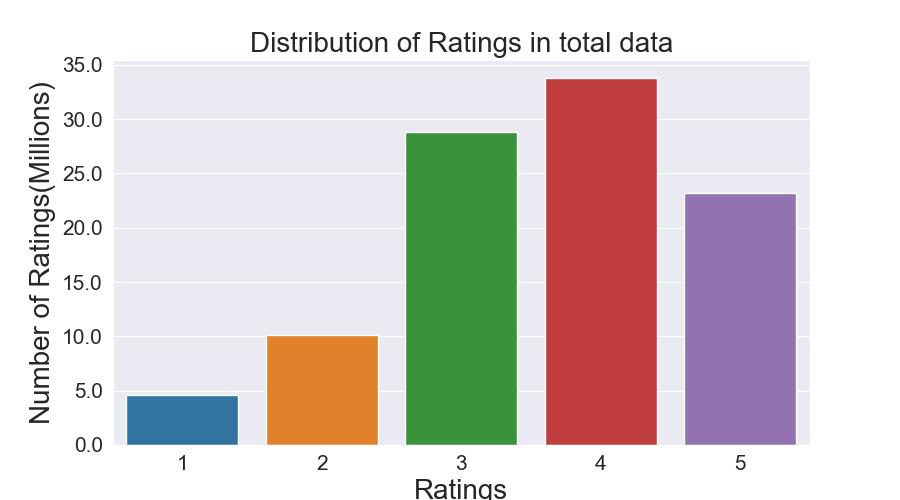

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import random

plt.figure(figsize = (9, 5))
ax = sns.countplot(x="currentRating", data=data_frame)

ax.set_yticklabels([str(num/10**6) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in total data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.show()

In [9]:
data_frame.iloc[:int(data_frame.shape[0]*0.80)].to_csv("./train.csv", index=False)
train_data = pd.read_csv("./train.csv", parse_dates=['date'])

data_frame.iloc[int(data_frame.shape[0]*0.80):].to_csv("./test.csv", index=False)
test_data = pd.read_csv("./test.csv")

In [11]:
print("Train Data:")
print("Number of movie ratings  = "+str(train_data.shape[0]))
print("Number of users = "+str(len(np.unique(train_data["userId"]))))
print("Number of movies = "+str(len(np.unique(train_data["movieId"]))))
print("Largest User ID = "+str(max(train_data["userId"].values)))
print("Largest Movie ID = "+str(max(train_data["movieId"].values)))

Train Data:
Number of movie ratings  = 80384405
Number of users = 405041
Number of movies = 17424
Largest User ID = 2649429
Largest Movie ID = 17770


In [12]:
print("Test Data:")
print("Number of movie ratings  = "+str(test_data.shape[0]))
print("Number of users = "+str(len(np.unique(test_data["userId"]))))
print("Number of movies = "+str(len(np.unique(test_data["movieId"]))))
print("Largest User ID = "+str(max(test_data["userId"].values)))
print("Largest Movie ID = "+str(max(test_data["movieId"].values)))

Test Data:
Number of movie ratings  = 20096102
Number of users = 349312
Number of movies = 17757
Largest User ID = 2649429
Largest Movie ID = 17770


In [41]:
from scipy import sparse
from scipy.sparse import csr_matrix

sparseMatrixTrain = sparse.csr_matrix((train_data.currentRating.values, (train_data.userId.values,train_data.movieId.values)),)
sparse.save_npz("spareMatrixTrain.npz", sparseMatrixTrain)
sparseMatrixTest = sparse.csr_matrix((test_data.currentRating.values, (test_data.userId.values,test_data.movieId.values)))
sparse.save_npz("sparseMatrixTest.npz", sparseMatrixTest)
print("Sparsity Of Train matrix : {} % ".format((1-(sparseMatrixTrain.count_nonzero()/(sparseMatrixTrain.shape[0]*sparseMatrixTrain.shape[1]))) * 100) )
print("Sparsity Of Test matrix : {} % ".format((1-(sparseMatrixTest.count_nonzero()/(sparseMatrixTest.shape[0]*sparseMatrixTest.shape[1]))) * 100) )

Sparsity Of Train matrix : 99.8292709259195 % 
Sparsity Of Test matrix : 99.95731772988694 % 


In [2]:
from scipy import sparse
from scipy.sparse import csr_matrix

In [42]:
print("Average movie rating : {}".format(sparseMatrixTrain.sum()/sparseMatrixTrain.count_nonzero()))

Average movie rating : 3.582890686321557


In [43]:
def usersRating(user = None):
    avg_rating = {}
    sum_of_ratings = sparseMatrixTrain.sum(axis=1).A1
    is_rated = sparseMatrixTrain!=0
    no_of_ratings = is_rated.sum(axis=1).A1
    for i in range(sparseMatrixTrain.shape[0]):
        if no_of_ratings[i] !=0:
            avg_rating[i] = sum_of_ratings[i]/no_of_ratings[i]
            
    return avg_rating[user] if user is not None else avg_rating

print("Average rating given by user 2104 is {}".format(usersRating(2104)))

Average rating given by user 2104 is 2.6254980079681274


In [44]:
def movieRating(movie = None):
    avg_rating = {}
    sum_of_ratings = sparseMatrixTrain.sum(axis=0).A1
    is_rated = sparseMatrixTrain!=0
    no_of_ratings = is_rated.sum(axis=0).A1
    for i in range(sparseMatrixTrain.shape[1]):
        if no_of_ratings[i] !=0:
            avg_rating[i] = sum_of_ratings[i]/no_of_ratings[i]
    return avg_rating[movie] if movie is not None else avg_rating


print("Average rating of movie 20 is {}".format(movieRating(20)))
    

Average rating of movie 20 is 3.119565217391304


In [47]:
# Computing User-User Similarity matrix
no_of_users, _ = sparseMatrixTrain.shape
org_rows, org_cols = sparseMatrixTrain.nonzero()
org_rows = sorted(set(org_rows))
top = 100
rows, cols, data = list(), list(), list()
usr = 0
for row in org_rows[:top]:
    usr = usr + 1
    sim = cosine_similarity(sparseMatrixTrain.getrow(row), sparseMatrixTrain).ravel()
    idx = sim.argsort()[-top:]
    val = sim[idx]
    rows.extend([row] * top)
    cols.extend(idx)
    data.extend(val)
    if usr % 20 == 0:
        print("computing done for "+str(usr)+" users")

UserSimilarity = sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users))
sparse.save_npz("./UserSimilarityMatrix.npz", UserSimilarity)
UserSimilarity = sparse.load_npz("./UserSimilarityMatrix.npz")
print('User Similarity Matrix Shape', UserSimilarity.shape)

computing done for 20 users
computing done for 40 users
computing done for 60 users
computing done for 80 users
computing done for 100 users
User Similarity Matrix Shape (2649430, 2649430)


In [49]:
# Computing Movie-Movie Similarity matrix
MovieSimilarity = cosine_similarity(sparseMatrixTrain.T, dense_output=False)
sparse.save_npz("./MovieSimilarityMatrix.npz", MovieSimilarity)
MovieSimilarity = sparse.load_npz("./MovieSimilarityMatrix.npz")
print('Movie Similarity Matrix Shape', MovieSimilarity.shape)

Movie Similarity Matrix Shape (17771, 17771)


In [52]:
movie_ids = np.unique(MovieSimilarity.nonzero()[1])
def getSimilarMovies(movie = None):
    similar_movies = {}
    for movie in movie_ids:
        sim_movies = MovieSimilarity[movie].toarray().ravel().argsort()[::-1][1:]
        similar_movies[movie] = sim_movies[:100]
    
    return similar_movies[movie] if movie is not None else similar_movies

print("Similar Movies for movie 9837 are : {}".format(getSimilarMovies(9837)))

Similar Movies for movie 9837 are : [17768 10600 10165 11897 16759 16348  5893  8152  2029  1723  8471 15377
  7486 17287 16092 11516   216  8942  6293  9887 10306    16 10243 14247
 17082  1787 15562   131  5271  8646  5744 11988  3567 17368  9871  1819
 16232  3631 15547 13538  3056 15867 16257 14227 13938  1260 17168 14002
  4210  5481 14292  6230 11865  5141  6193  1171 17447 13616 17609  5426
  7046  6585   341 10366 12808  3049  1371 13873 15589  9126  4165   684
 13318 15234  4645  2720 14169 11938 14531  1116 15885 10303  3540 16386
 12472 16485 14555  5059 13268   122  3525  1693  7438 16279  1803   470
 15246  7442 11771 12171]


In [54]:
movie_titles = pd.read_csv("movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")
movie_titles

Tokenization took: 5.89 ms
Type conversion took: 40.13 ms
Parser memory cleanup took: 0.01 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
...,...,...
17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17767,2004.0,Fidel Castro: American Experience
17768,2000.0,Epoch


In [55]:
def getSimilarMovieNames(movie):
    similarities = MovieSimilarity[movie].toarray().ravel()
    similar_indices = similarities.argsort()[::-1][1:]
    similarities[similar_indices]
    sim_indices = similarities.argsort()[::-1][1:]
    return movie_titles.loc[sim_indices[:10]]

print(getSimilarMovieNames(9837))
    

          year_of_release                 title
movie_id                                       
10897              1978.0                   Don
13606              1975.0               Deewaar
2706               1981.0        Satte Pe Satta
8759               1975.0                Sholay
8285               1970.0                 Anand
10755              2000.0              Abhimaan
5780               1978.0  Muqaddar Ka Sikandar
633                1993.0              Baazigar
2055               1994.0       Andaz Apna Apna
13160              1992.0                  Roja


In [56]:
def sampled__sparse__matrix(sparse_matrix, number_of_users, number_of_movies, path):
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    total_users = np.unique(row_ind)
    total_movies = np.unique(col_ind)
    np.random.seed(15)
    sampled_users = np.random.choice(total_users, number_of_users, replace=False)
    sampled_movies = np.random.choice(total_movies, number_of_movies, replace=False)
    mask = np.logical_and(np.isin(row_ind, sampled_users),
                          np.isin(col_ind, sampled_movies))

    sampled__sparse__matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sampled_users) + 1, max(sampled_movies) + 1))

    sparse.save_npz(path, sampled__sparse__matrix)
    return sampled__sparse__matrix

In [57]:
path = "sample_spareMatrixTrain.npz"
if os.path.isfile(path):
    sample_train_SM = sparse.load_npz(path)
else: 
    sample_train_SM = sampled__sparse__matrix(sparseMatrixTrain, no_users=30000, no_movies=5000,path = path)

path = "sample_sparseMatrixTest.npz"
if os.path.isfile(path):
    sample_test_SM = sparse.load_npz(path)
else:
    sample_test_SM = sampled__sparse__matrix(sparseMatrixTest, no_users=5000, no_movies=1000,
                                                 path = path)

In [58]:
regression_train = pd.read_csv('regression_model_train.csv', names = ['user', 'movie', 'Global_Avg', 'Similar_user_1', 'Similar_user_2', 'Similar_user_3', 'Similar_user_4', 'Similar_user_5','Similar_movie_rating_1', 'Similar_movie_rating_2', 'Similar_movie_rating_3', 'Similar_movie_rating_4', 'Similar_movie_rating_5', 'User_Avg', 'Movie_Avg', 'rating'], header=None)
regression_train.head(20)

,user,movie,Global_Avg,Similar_user_1,Similar_user_2,Similar_user_3,Similar_user_4,Similar_user_5,Similar_movie_rating_1,Similar_movie_rating_2,Similar_movie_rating_3,Similar_movie_rating_4,Similar_movie_rating_5,User_Avg,Movie_Avg,rating
0,124742,5,3.585633,4.0,5.0,1.0,1.0,3.0,4.0,3.0,5.0,3.0,5.0,3.700787,4.142857,5
1,261262,5,3.585633,5.0,5.0,5.0,5.0,5.0,3.0,2.0,5.0,2.0,2.8,2.800000,4.142857,2
2,273956,5,3.585633,3.0,5.0,4.0,5.0,5.0,4.0,3.0,3.0,2.0,4.0,3.224490,4.142857,5
3,282064,5,3.585633,5.0,5.0,5.0,4.0,5.0,3.0,5.0,4.0,3.0,3.0,3.694444,4.142857,5
4,284978,5,3.585633,5.0,1.0,4.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,4.561644,4.142857,5
5,371814,5,3.585633,5.0,3.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.857143,4.142857,5
6,433426,5,3.585633,5.0,5.0,5.0,4.0,5.0,3.0,4.0,3.0,4.0,3.0,3.277778,4.142857,5
7,473435,5,3.585633,5.0,5.0,3.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,3.666667,4.142857,5
8,524113,5,3.585633,4.0,1.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.144737,4.142857,5
9,526348,5,3.585633,2.0,5.0,5.0,4.0,1.0,5.0,5.0,1.0,1.0,3.0,3.000000,4.142857,5


In [59]:
regression_test = pd.read_csv('reg_model_test.csv', names = ['user', 'movie', 'Global_Avg', 'Similar_user_1', 'Similar_user_2', 'Similar_user_3', 'Similar_user_4', 'Similar_user_5','Similar_movie_rating_1', 'Similar_movie_rating_2', 'Similar_movie_rating_3', 'Similar_movie_rating_4', 'Similar_movie_rating_5', 'User_Avg', 'Movie_Avg', 'rating'], header=None)
regression_test.head(20)

,user,movie,Global_Avg,Similar_user_1,Similar_user_2,Similar_user_3,Similar_user_4,Similar_user_5,Similar_movie_rating_1,Similar_movie_rating_2,Similar_movie_rating_3,Similar_movie_rating_4,Similar_movie_rating_5,User_Avg,Movie_Avg,rating
0,808635,71,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,5
1,941866,71,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
2,1737912,71,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3
3,1849204,71,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
4,2227850,90,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
5,28572,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,1
6,117617,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
7,243739,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
8,303901,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3
9,310887,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4


In [60]:
regression_train = pd.read_csv('regression_model_train.csv', names = ['user', 'movie', 'Global_Avg', 'Similar_user_1', 'Similar_user_2', 'Similar_user_3', 'Similar_user_4', 'Similar_user_5','Similar_movie_rating_1', 'Similar_movie_rating_2', 'Similar_movie_rating_3', 'Similar_movie_rating_4', 'Similar_movie_rating_5', 'User_Avg', 'Movie_Avg', 'rating'], header=None)
regression_train.head(10)

,user,movie,Global_Avg,Similar_user_1,Similar_user_2,Similar_user_3,Similar_user_4,Similar_user_5,Similar_movie_rating_1,Similar_movie_rating_2,Similar_movie_rating_3,Similar_movie_rating_4,Similar_movie_rating_5,User_Avg,Movie_Avg,rating
0,124742,5,3.585633,4.0,5.0,1.0,1.0,3.0,4.0,3.0,5.0,3.0,5.0,3.700787,4.142857,5
1,261262,5,3.585633,5.0,5.0,5.0,5.0,5.0,3.0,2.0,5.0,2.0,2.8,2.800000,4.142857,2
2,273956,5,3.585633,3.0,5.0,4.0,5.0,5.0,4.0,3.0,3.0,2.0,4.0,3.224490,4.142857,5
3,282064,5,3.585633,5.0,5.0,5.0,4.0,5.0,3.0,5.0,4.0,3.0,3.0,3.694444,4.142857,5
4,284978,5,3.585633,5.0,1.0,4.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,4.561644,4.142857,5
5,371814,5,3.585633,5.0,3.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.857143,4.142857,5
6,433426,5,3.585633,5.0,5.0,5.0,4.0,5.0,3.0,4.0,3.0,4.0,3.0,3.277778,4.142857,5
7,473435,5,3.585633,5.0,5.0,3.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,3.666667,4.142857,5
8,524113,5,3.585633,4.0,1.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.144737,4.142857,5
9,526348,5,3.585633,2.0,5.0,5.0,4.0,1.0,5.0,5.0,1.0,1.0,3.0,3.000000,4.142857,5


In [61]:
regression_test = pd.read_csv('reg_model_test.csv', names = ['user', 'movie', 'Global_Avg', 'Similar_user_1', 'Similar_user_2', 'Similar_user_3', 'Similar_user_4', 'Similar_user_5','Similar_movie_rating_1', 'Similar_movie_rating_2', 'Similar_movie_rating_3', 'Similar_movie_rating_4', 'Similar_movie_rating_5', 'User_Avg', 'Movie_Avg', 'rating'], header=None)
regression_test.head(10)

,user,movie,Global_Avg,Similar_user_1,Similar_user_2,Similar_user_3,Similar_user_4,Similar_user_5,Similar_movie_rating_1,Similar_movie_rating_2,Similar_movie_rating_3,Similar_movie_rating_4,Similar_movie_rating_5,User_Avg,Movie_Avg,rating
0,808635,71,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,5
1,941866,71,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
2,1737912,71,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3
3,1849204,71,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
4,2227850,90,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
5,28572,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,1
6,117617,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
7,243739,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
8,303901,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3
9,310887,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4


In [66]:
from surprise import Reader, Dataset
from surprise import KNNBaseline
from surprise import BaselineOnly

read = Reader(rating_scale=(1,5))
trainedData = Dataset.load_from_df(regression_train[['user', 'movie', 'rating']], read)
trainedSet = trainedData.build_full_trainset()
testSet = list(zip(regression_test.user.values, regression_test.movie.values, regression_test.rating.values))

trainModelEvaluation = dict()
testModelEvaluation = dict()

In [67]:
def getErrorMetrics(yActual, yPred):
    rmse = np.sqrt(np.mean([ (yActual[i] - yPred[i])**2 for i in range(len(yPred)) ]))
    mape = np.mean(np.abs( (yActual - yPred)/yActual )) * 100
    return rmse, mape

def runXgboost(model,  xTrain, yTrain, xTest, yTest):
    trainResults = dict()
    testResults = dict()
    start =datetime.now()
    model.fit(xTrain, yTrain, eval_metric = 'rmse')
    
    start =datetime.now()
    yTrainPred = model.predict(xTrain)
    rmseTrain, mapeTrain = getErrorMetrics(yTrain.values, yTrainPred)
    
    trainResults = {'rmse': rmseTrain,
                    'mape' : mapeTrain,
                    'predictions' : yTrainPred}
    
    yTestPred = model.predict(xTest) 
    rmseTest, mapeTest = getErrorMetrics(yActual=yTest.values, yPred=yTestPred)
    
    testResults = {'rmse': rmseTest,
                    'mape' : mapeTest,
                    'predictions':yTestPred}
    
    return trainResults, testResults

In [68]:
SeedVal = 15
random.seed(SeedVal)
np.random.seed(SeedVal)

def getRatings(predictions):
    actual = np.array([predict.r_ui for predict in predictions])
    predicts = np.array([predict.est for predict in predictions])
    
    return actual, predicts

def getErrors(predicts, printThem=False):

    actual, predict = getRatings(predicts)
    rmse = np.sqrt(np.mean((predict - actual)**2))
    mape = np.mean(np.abs(predict - actual)/actual)

    return rmse, mape*100

In [69]:
def runSurprise(model, trainSet, testSet, verbose=True): 
    
    start = datetime.now()
    trainResult = dict()
    testResult = dict()
    
    start = datetime.now()
    model.fit(trainSet)
    start = datetime.now()
    trainPreds = model.test(trainSet.build_testset())
    trainActual, trainPredict = getRatings(trainPreds)
    trainRmse, trainMape = getErrors(trainPreds)
    trainResult['rmse'] = trainRmse
    trainResult['mape'] = trainMape
    trainResult['predictions'] = trainPredict
    start = datetime.now()
    testPreds = model.test(testSet)
    testActual, testPredict = getRatings(testPreds)
    testRmse, testMape = getErrors(testPreds)    
    testResult['rmse'] = testRmse
    testResult['mape'] = testMape
    testResult['predictions'] = testPredict
    
    return trainResult, testResult

In [75]:
#1. XGBoost 

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xTrain = regression_train.drop(['user','movie','rating'], axis=1)
yTrain = regression_train['rating']

xTrain = xTrain.iloc[:5000,:]
yTrain = yTrain.iloc[:5000,]

xTest = regression_test.drop(['user','movie','rating'], axis=1)
yTest = regression_test['rating']

parameters={'n_estimators':[20,40,60,80,100,120,140,160,180,200,220,240,260],
           'max_depth':[3,6,9,12,15,18,21,24,27,30]}


firstXgb = xgb.XGBRegressor(verbosity=0, n_jobs=-1, random_state=15)
xb = GridSearchCV(firstXgb,param_grid=parameters)
xb.fit(xTrain,yTrain)
trainResults, testResults = runXgboost(xb.best_estimator_, xTrain, yTrain, xTest, yTest)

trainModelEvaluation['XGBoost'] = trainResults
testModelEvaluation['XGBoost'] = testResults

In [78]:
#KnnBaseLine


bsl_options={'learning_rate':0.01,'method':'sgd'}


'''parameters ={'sim_options':{'shrinkage':[100],
                            'min_support': [2]},
             'bsl_options':{'method':['sgd']                           
                           },
             'k':[60]
             }'''
sim_options={'shrinkage':100,'min_support': 2}
knnBase = KNNBaseline(k=40,min_k = 1, sim_options = sim_options,bsl_options = bsl_options)
#baseLine = BaselineOnly(bsl_options=bsl_options)
#print(trainedSet)
#print(testSet)
knnTrainResults, knnTestResults = runSurprise(knnBase,trainedSet, testSet)
trainModelEvaluation['KNN_Baseline_User'] = knnTrainResults 
testModelEvaluation['KNN_Baseline_User'] = knnTestResults

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [83]:
#For 6 lakh records
reg_train_2 = pd.read_csv('regression_model_train_2.csv', names = ['user', 'movie', 'Global_Avg', 'Similar_user_1', 'Similar_user_2', 'Similar_user_3', 'Similar_user_4', 'Similar_user_5','Similar_movie_rating_1', 'Similar_movie_rating_2', 'Similar_movie_rating_3', 'Similar_movie_rating_4', 'Similar_movie_rating_5', 'User_Avg', 'Movie_Avg', 'rating'], header=None)
reg_train_2.head(20)

reg_test_df = pd.read_csv('reg_model_test.csv', names = ['user', 'movie', 'Global_Avg', 'Similar_user_1', 'Similar_user_2', 'Similar_user_3', 'Similar_user_4', 'Similar_user_5','Similar_movie_rating_1', 'Similar_movie_rating_2', 'Similar_movie_rating_3', 'Similar_movie_rating_4', 'Similar_movie_rating_5', 'User_Avg', 'Movie_Avg', 'rating'], header=None)
reg_test_df.head(20)

xTrain2 = reg_train_2.drop(['user','movie','rating'], axis=1)
yTrain2 = reg_train_2['rating']

xTrain2 = xTrain2.iloc[:5000,:]
yTrain2 = yTrain2.iloc[:5000,]

xTest2 = reg_test_df.drop(['user','movie','rating'], axis=1)
yTest2 = reg_test_df['rating']

parameters={'n_estimators':[20,40,60,80,100,120,140,160,180,200,220,240,260],
           'max_depth':[3,6,9,12,15,18,21,24,27,30]}


secondXgb = xgb.XGBRegressor(verbosity=0, n_jobs=-1, random_state=15)
xb2 = GridSearchCV(secondXgb,param_grid=parameters,cv=None)
xb2.fit(xTrain2,yTrain2)
trainResults2, testResults2 = runXgboost(xb2.best_estimator_, xTrain2, yTrain2, xTest2, yTest2)


trainModelEvaluation['XGBoost2'] = trainResults2
testModelEvaluation['XGBoost2'] = testResults2

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [82]:
#KnnBaseLine for 6 lakh records

reg_train_2 = pd.read_csv('regression_model_train_2.csv', names = ['user', 'movie', 'Global_Avg', 'Similar_user_1', 'Similar_user_2', 'Similar_user_3', 'Similar_user_4', 'Similar_user_5','Similar_movie_rating_1', 'Similar_movie_rating_2', 'Similar_movie_rating_3', 'Similar_movie_rating_4', 'Similar_movie_rating_5', 'User_Avg', 'Movie_Avg', 'rating'], header=None)
reg_train_2.head(20)

regression_test = pd.read_csv('reg_model_test.csv', names = ['user', 'movie', 'Global_Avg', 'Similar_user_1', 'Similar_user_2', 'Similar_user_3', 'Similar_user_4', 'Similar_user_5','Similar_movie_rating_1', 'Similar_movie_rating_2', 'Similar_movie_rating_3', 'Similar_movie_rating_4', 'Similar_movie_rating_5', 'User_Avg', 'Movie_Avg', 'rating'], header=None)
regression_test.head(20)

read = Reader(rating_scale=(1,5))
trainedData = Dataset.load_from_df(reg_train_2[['user', 'movie', 'rating']], read)
trainedSet = trainedData.build_full_trainset()

testSet = list(zip(regression_test.user.values, regression_test.movie.values, regression_test.rating.values))
testSet[:3]


bsl_options={'learning_rate':0.01,'method':'sgd'}


'''parameters ={'sim_options':{'shrinkage':[100],
                            'min_support': [2]},
             'bsl_options':{'method':['sgd']                           
                           },
             'k':[60]
             }'''
sim_options={'shrinkage':100,'min_support': 2}
knnBase = KNNBaseline(k=40,min_k = 1, sim_options = sim_options,bsl_options = bsl_options)
#baseLine = BaselineOnly(bsl_options=bsl_options)
#print(trainedSet)
#print(testSet)
knnTrainResults2, knnTestResults2 = runSurprise(knnBase,trainedSet, testSet)
trainModelEvaluation['KNN_Baseline_User_2'] = knnTrainResults2 
testModelEvaluation['KNN_Baseline_User_2'] = knnTestResults2

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [85]:
from surprise import SVD
svd_train_results, svd_test_results = runSurprise(SVD(n_factors=20), trainedSet, testSet, verbose=True)
trainModelEvaluation['SVD'] = svd_train_results 
testModelEvaluation['SVD'] = svd_test_results

In [86]:
pd.DataFrame(testModelEvaluation).loc['rmse'].sort_values()

KNN_Baseline_User      1.07551
XGBoost                1.07789
XGBoost2               1.07789
SVD                    1.07938
KNN_Baseline_User_2    1.07999
Name: rmse, dtype: object

In [4]:
PATH = "./"
MovieSimilarity = sparse.load_npz(PATH+"MovieSimilarityMatrix.npz")

In [ ]:
import anvil.server

anvil.server.connect("6ETZOBKBB3BBWZGC4ZFDG4UZ-DEVALROKLW6U73XU")

from anvil.tables import app_tables

@anvil.server.callable
def helper(my_id):
    similarities = MovieSimilarity[my_id].toarray().ravel()
    similar_indices = similarities.argsort()[::-1][1:]
    similarities[similar_indices]
    sim_indices = similarities.argsort()[::-1][1:]
    #print((movie_titles.loc[sim_indices[:10]]))
    return ((movie_titles.loc[sim_indices[:10]]))


@anvil.server.callable
def recommendName(search):
    id = movie_titles[movie_titles['title']==search]
    id = id.index.values[0]
    #print(id)
    table = helper(id)
    print(type(table))
    list_of_dicts=table.to_dict('records')
    return list_of_dicts
#     for d in list_of_dicts:
#         print(d)
#         app_tables.movies_table.add_row(movie_name="Movie",year_no="1999")
#     for index, row in table.iterrows():
#         print(index+" "+row['title']+" "+row['year_of_release'])
        #app_tables.movies_table.add_row(movie_name=row['title'], year_no=row['year_of_release'])
@anvil.server.callable
def rating_id(search):
    id = movie_titles[movie_titles['title']==search]
    id = id.index.values[0]
    #print(id)
    avg_movie_rating = movieRating(id)
    return avg_movie_rating
@anvil.server.callable
def get_employees():
  #app_tables.movies_table.delete_all_rows()
  return app_tables.movies_table.search()

anvil.server.wait_forever()